**Text classification with RNN**

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt


In [0]:
def plot_graph(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel('epochs')
  plt.ylabel(metric)
  plt.show()

In [0]:
#The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteIPACWS/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteIPACWS/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteIPACWS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
encoder = info.features['text'].encoder
print('vocabulary size: {}'.format(encoder.vocab_size))

vocabulary size: 8185


In [0]:
# this encoder will reversly encode any string, falling back to byte-encoding if necessary.

sample_string = 'Hello Tensorflow'
encoder_string = encoder.encode((sample_string))
print("encoder string: {}".format(encoder_string))

original_string = encoder.decode((encoder_string))
print('original string: {}'.format(original_string))

encoder string: [4025, 222, 6307, 2327, 2934]
original string: Hello Tensorflow


In [0]:
assert original_string == sample_string

for index in encoder_string:
  print('{}--->{}'.format(index, encoder.decode([index])))

4025--->Hell
222--->o 
6307--->Ten
2327--->sor
2934--->flow


In [0]:
# Prepare the data for training size

BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [0]:
#Create the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs = 5, validation_data = test_dataset, validation_steps=30)

Epoch 1/5
391/391 [==============================] - 833s 2s/step - loss: 0.6554 - accuracy: 0.5513 - val_loss: 0.4757 - val_accuracy: 0.7615
Epoch 2/5
391/391 [==============================] - 848s 2s/step - loss: 0.3514 - accuracy: 0.8531 - val_loss: 0.3439 - val_accuracy: 0.8500
Epoch 3/5
391/391 [==============================] - 853s 2s/step - loss: 0.2633 - accuracy: 0.8974 - val_loss: 0.3340 - val_accuracy: 0.8672
Epoch 4/5
391/391 [==============================] - 853s 2s/step - loss: 0.2194 - accuracy: 0.9173 - val_loss: 0.3453 - val_accuracy: 0.8667
Epoch 5/5
391/391 [==============================] - 849s 2s/step - loss: 0.1867 - accuracy: 0.9326 - val_loss: 0.3600 - val_accuracy: 0.8604


In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('test loss', test_loss)
print('test accuracy', test_acc)

391/391 [==============================] - 180s 460ms/step - loss: 0.3549 - accuracy: 0.8654


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would use masking to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.1268618]]


In [0]:
# Prediction on sample text without padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = True)
print(predictions)

[[0.1078748]]


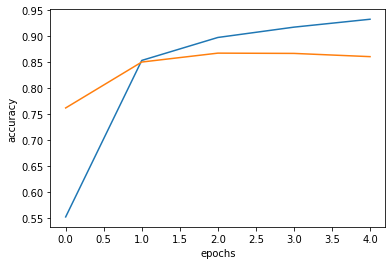

In [0]:
plot_graph(history, 'accuracy')

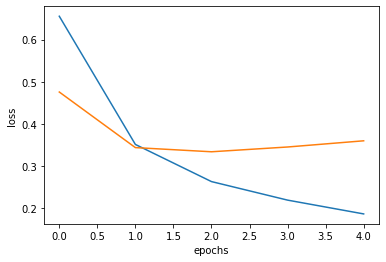

In [0]:
plot_graph(history, 'loss')

Stack two or more LSTM layers

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs = 3, validation_data = test_dataset, validation_steps = 30)

Epoch 1/3
391/391 [==============================] - 1570s 4s/step - loss: 0.6515 - accuracy: 0.5600 - val_loss: 0.4737 - val_accuracy: 0.7667
Epoch 2/3
309/391 [======================>.......] - ETA: 5:22 - loss: 0.3795 - accuracy: 0.8440

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print("test_loss", test_loss)
print("test_accuracy", test_acc)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [0]:
plot_graphs(history, 'loss')

In [0]:
plot_graphs(history, 'accuracy')

Resource: https://www.tensorflow.org/tutorials/text/text_classification_rnn